# t-SNE tutorial

## imports

In [1]:
from contextlib import ExitStack
import numpy as np
from sklearn.manifold import TSNE
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import MDS, Isomap
from sklearn.manifold import LocallyLinearEmbedding as LLE
import pandas as pd
import os
import codecs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## plotting 

In [2]:
def draw(parameters, labels, dim=2, cmap_name='brg'):
    keys  = set(labels)
    numeration = list(range(1,len(keys)+1))
    label_map = dict(zip(keys,numeration))
    print(label_map)
    cx = [label_map[l] for l in labels] 
    if(dim==3):
        x = parameters[:,0]
        y = parameters[:,1]
        z = parameters[:,2]
        fig = plt.figure()
        ax = Axes3D(plt.figure())
        ax.scatter(x, y, z, c=cx, cmap=plt.get_cmap(cmap_name))
        
    else:
        x = parameters[:,0]
        y = parameters[:,1]
        fig = plt.figure(figsize=(8,8))
        plt.scatter(x, y, c=cx, cmap=plt.get_cmap(cmap_name))

## manifold methods

In [3]:
def scale_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

def perform_pca(data, number_of_components, scale=False):
    if scale:
        data = scale_data(data)
    pca = PCA(n_components=number_of_components)
    components = pca.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    return components_dataframe

def perform_kernel_pca(data, number_of_components, scale=False):
    if scale:
        data = scale_data(data)
    kpca = KernelPCA(kernel="rbf", n_components=number_of_components)
    components = kpca.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    return components_dataframe

def perform_mds(data, number_of_components, scale=False):
    if scale:
        data = scale_data(data)
    mds = MDS(n_components=number_of_components)
    components = mds.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    return components_dataframe
    
def perform_isomap(data, number_of_components, number_of_neighbors, scale=False):
    if scale:
        data = scale_data(data)
    iso = Isomap(n_neighbors=number_of_neighbors, n_components=number_of_components)
    components = iso.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    return components_dataframe

def perform_lle(data, number_of_components, number_of_neighbors, scale=False):
    if scale:
        data = scale_data(data)
    lle = LLE(n_neighbors=number_of_neighbors, n_components=number_of_components, eigen_solver='arpack')
    components = lle.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    return components_dataframe

In [4]:
def perform_tsne(data, number_of_components, perplex=30.0, scale=False, calc_method='barnes_hut'):
    if scale:
        data = scale_data(data)
    tsne = TSNE(n_components=number_of_components, perplexity=perplex, method=calc_method)
    components = tsne.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    return components_dataframe

## preprocessing

In [5]:
filesdir = "20news-bydate-train/"   # path to 20news-bydate-train/ remember to put '/' at the end
labels = [fname for fname in os.listdir(filesdir) if not fname.startswith('.')]
dirs = [filesdir + label for label in labels][:3]
files = [os.listdir(directory) for directory in dirs][:3]
lengths = [len(f) for f in files]
lengths
multiplied_labels = [[label]*length for label,length in zip(labels,lengths)]
flat_labels = [x for sublist in multiplied_labels for x in sublist]
flat_files = [x for sublist in files for x in sublist]
flat_files = [filesdir + flat_label + '/' + flat_file for flat_label,flat_file in zip(flat_labels,flat_files)]

filenames = flat_files

stemmer = SnowballStemmer('english')
analyzer = TfidfVectorizer().build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))


with ExitStack() as stack:
    
    files = []
    for fname in filenames:
        with codecs.open(fname, 'r', encoding='utf-8',
                 errors='ignore') as f:
            files.append(stack.enter_context(f).read())
            f.close()
    vectorizer = TfidfVectorizer(stop_words='english', analyzer=stemmed_words)
    Y = vectorizer.fit_transform(files).todense()

## performing t-sne

In [6]:
pca = PCA(n_components=20)
components = pca.fit_transform(Y)

In [7]:
X_embedded = TSNE(n_components=3, perplexity=50.0).fit_transform(components)

print(X_embedded)

[[  7.0217247  10.930694    3.8953218]
 [ -0.8105624  -5.6002645  -1.8755484]
 [  7.9300575  14.659691   19.530401 ]
 ...
 [  4.741512    6.0279365  24.609764 ]
 [-23.37983     5.160637   13.743641 ]
 [  1.9878246   9.207745   17.559216 ]]


{'comp.graphics': 1, 'alt.atheism': 2, 'comp.os.ms-windows.misc': 3}


<Figure size 432x288 with 0 Axes>

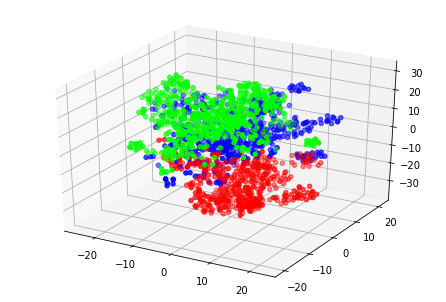

In [8]:
draw(X_embedded, flat_labels, dim=3)

## methods comparison

In [10]:
def knn_stats(samples, labels, n_neighbours):
    nbrs = NearestNeighbors(n_neighbours, algorithm='brute').fit(samples)
    distances, indices = nbrs.kneighbors(samples)
    
    neighbour_stats = []
    
    for index, neighbours in enumerate(indices):
        same_cluster_neighbours = filter(
            lambda neighbour: labels[neighbour] == labels[index],
            neighbours
        )
        neighbour_stats.append(len(list(same_cluster_neighbours)) / n_neighbours)
        
    return neighbour_stats

def k_nearest_neighbors(entry_dataset, computed_dataset, n_neighbors):
    
    nbrs_before = NearestNeighbors(n_neighbors, algorithm='brute').fit(entry_dataset)
    distances_before, indices_before = nbrs_before.kneighbors(entry_dataset)
    
    nbrs_after = NearestNeighbors(n_neighbors, algorithm='brute').fit(computed_dataset)
    distances_after, indices_after = nbrs_after.kneighbors(computed_dataset)
    
    neighbors_hit_list = []
    
    n = len(indices_before)
    
    for i in range(n):
        set_before= set(indices_before[i])
        set_after = set(indices_after[i])
        neighbors_hit_list.append(len(set_before.intersection(set_after)))
        
    return sum(neighbors_hit_list) / len(neighbors_hit_list)

In [ ]:
nbors = 15
stats = k_nearest_neighbors(Y, X_embedded, nbors)
print('tsne: ', stats, ' out of ', nbors, ' neighbors')